In [1]:
import datetime
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
def generate_data(
                raw_data_path = 'data/Final Data.xlsx',
                imputed_data_path = 'data/imputed data.xlsx',
                processed_data_path = 'data/processed data.xlsx',
                column_to_drop = ['Machine ID'],
                fabric_type_dict = {
                            'Heavy' : 1,
                            'Medium' : 0,
                            }
                ):
    if not os.path.exists(processed_data_path):
        data = pd.read_excel(raw_data_path)
        data = data.drop(
                        column_to_drop, 
                        axis=1
                        )
        data['Brand'] = 'Juki'
        data.to_excel(imputed_data_path, index=False)

        data['Brand'], data['Type'] = 0, 0
        data['Fabric_Type'] = data['Fabric_Type'].apply(lambda x: fabric_type_dict[x])
        data.to_excel(processed_data_path, index=False)
    
    data = pd.read_excel(processed_data_path)
    data = data.drop(['Brand', 'Type'], axis=1) 
    X = data[['Fabric_Type', 'M_Year']].values
    Y = data.drop(['Fabric_Type', 'M_Year'], axis=1).values

    if not os.path.exists('data/standard scalar.pkl'):
        sc = StandardScaler()
        sc.fit(X)
        with open('data/standard scalar.pkl', 'wb') as f:
            pickle.dump(sc, f)

    with open('data/standard scalar.pkl', 'rb') as f:
        sc = pickle.load(f)
        
    X = sc.transform(X)
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
    return X, Xtest, Y, Ytest

In [3]:
X, Xtest, Y, Ytest = generate_data()

print("Train Input Shape:", X.shape)
print("Train Output Shape:", Y.shape)
print("Test Input Shape:", Xtest.shape)
print("Test Output Shape:", Ytest.shape)

Train Input Shape: (1198, 2)
Train Output Shape: (1198, 10)
Test Input Shape: (240, 2)
Test Output Shape: (240, 10)


1.

In [4]:
rfr = RandomForestRegressor()
rfr = MultiOutputRegressor(rfr)
rfr.fit(X, Y)
print("Random Forest Regressor trained successfully ...")

xgbr = XGBRegressor()
xgbr = MultiOutputRegressor(xgbr)
xgbr.fit(X, Y)
print("XGBoost Regressor trained successfully ...")

Random Forest Regressor trained successfully ...
XGBoost Regressor trained successfully ...


In [5]:
# Predictions on training set
train_predictions_rfr = rfr.predict(X)
train_predictions_xgbr = xgbr.predict(X)

# Predictions on test set
test_predictions_rfr = rfr.predict(Xtest)
test_predictions_xgbr = xgbr.predict(Xtest)

#metrics for training set
mae_train_rfr = mean_absolute_error(Y, train_predictions_rfr)
mae_train_xgbr = mean_absolute_error(Y, train_predictions_xgbr)

mse_train_rfr = mean_squared_error(Y, train_predictions_rfr)
mse_train_xgbr = mean_squared_error(Y, train_predictions_xgbr)

r2_train_rfr = r2_score(Y, train_predictions_rfr)
r2_train_xgbr = r2_score(Y, train_predictions_xgbr)

print("Random Forest Regressor - Training Set Metrics:")
print("MAE:", mae_train_rfr)
print("R-squared:", r2_train_rfr)
print("---------------------------------------------")
print("XGBoost Regressor - Training Set Metrics:")
print("MAE:", mae_train_xgbr)
print("R-squared:", r2_train_xgbr)

#metrics for test set
mae_test_rfr = mean_absolute_error(Ytest, test_predictions_rfr)
mae_test_xgbr = mean_absolute_error(Ytest, test_predictions_xgbr)


r2_test_rfr = r2_score(Ytest, test_predictions_rfr)
r2_test_xgbr = r2_score(Ytest, test_predictions_xgbr)

print("---------------------------------------------")
print("Random Forest Regressor - Test Set Metrics:")
print("MAE:", mae_test_rfr)
print("R-squared:", r2_test_rfr)
print("---------------------------------------------")
print("XGBoost Regressor - Test Set Metrics:")
print("MAE:", mae_test_xgbr)
print("R-squared:", r2_test_xgbr)


Random Forest Regressor - Training Set Metrics:
MAE: 25.16429528949263
R-squared: 0.9169676476909089
---------------------------------------------
XGBoost Regressor - Training Set Metrics:
MAE: 25.06882
R-squared: 0.9169926386266983
---------------------------------------------
Random Forest Regressor - Test Set Metrics:
MAE: 24.56625204498827
R-squared: 0.9145914128062836
---------------------------------------------
XGBoost Regressor - Test Set Metrics:
MAE: 24.445822
R-squared: 0.9148778855422929


In [6]:
output_columns = [
                'Take up Spring', 'Take up Rubber', 'Bobbin Case', 'Feed Dog',
                'Presser Foot', 'Tension Assembly', 'Hook Assembly',
                'Timing Components','Oil Filling','Dust Remove'
                ]

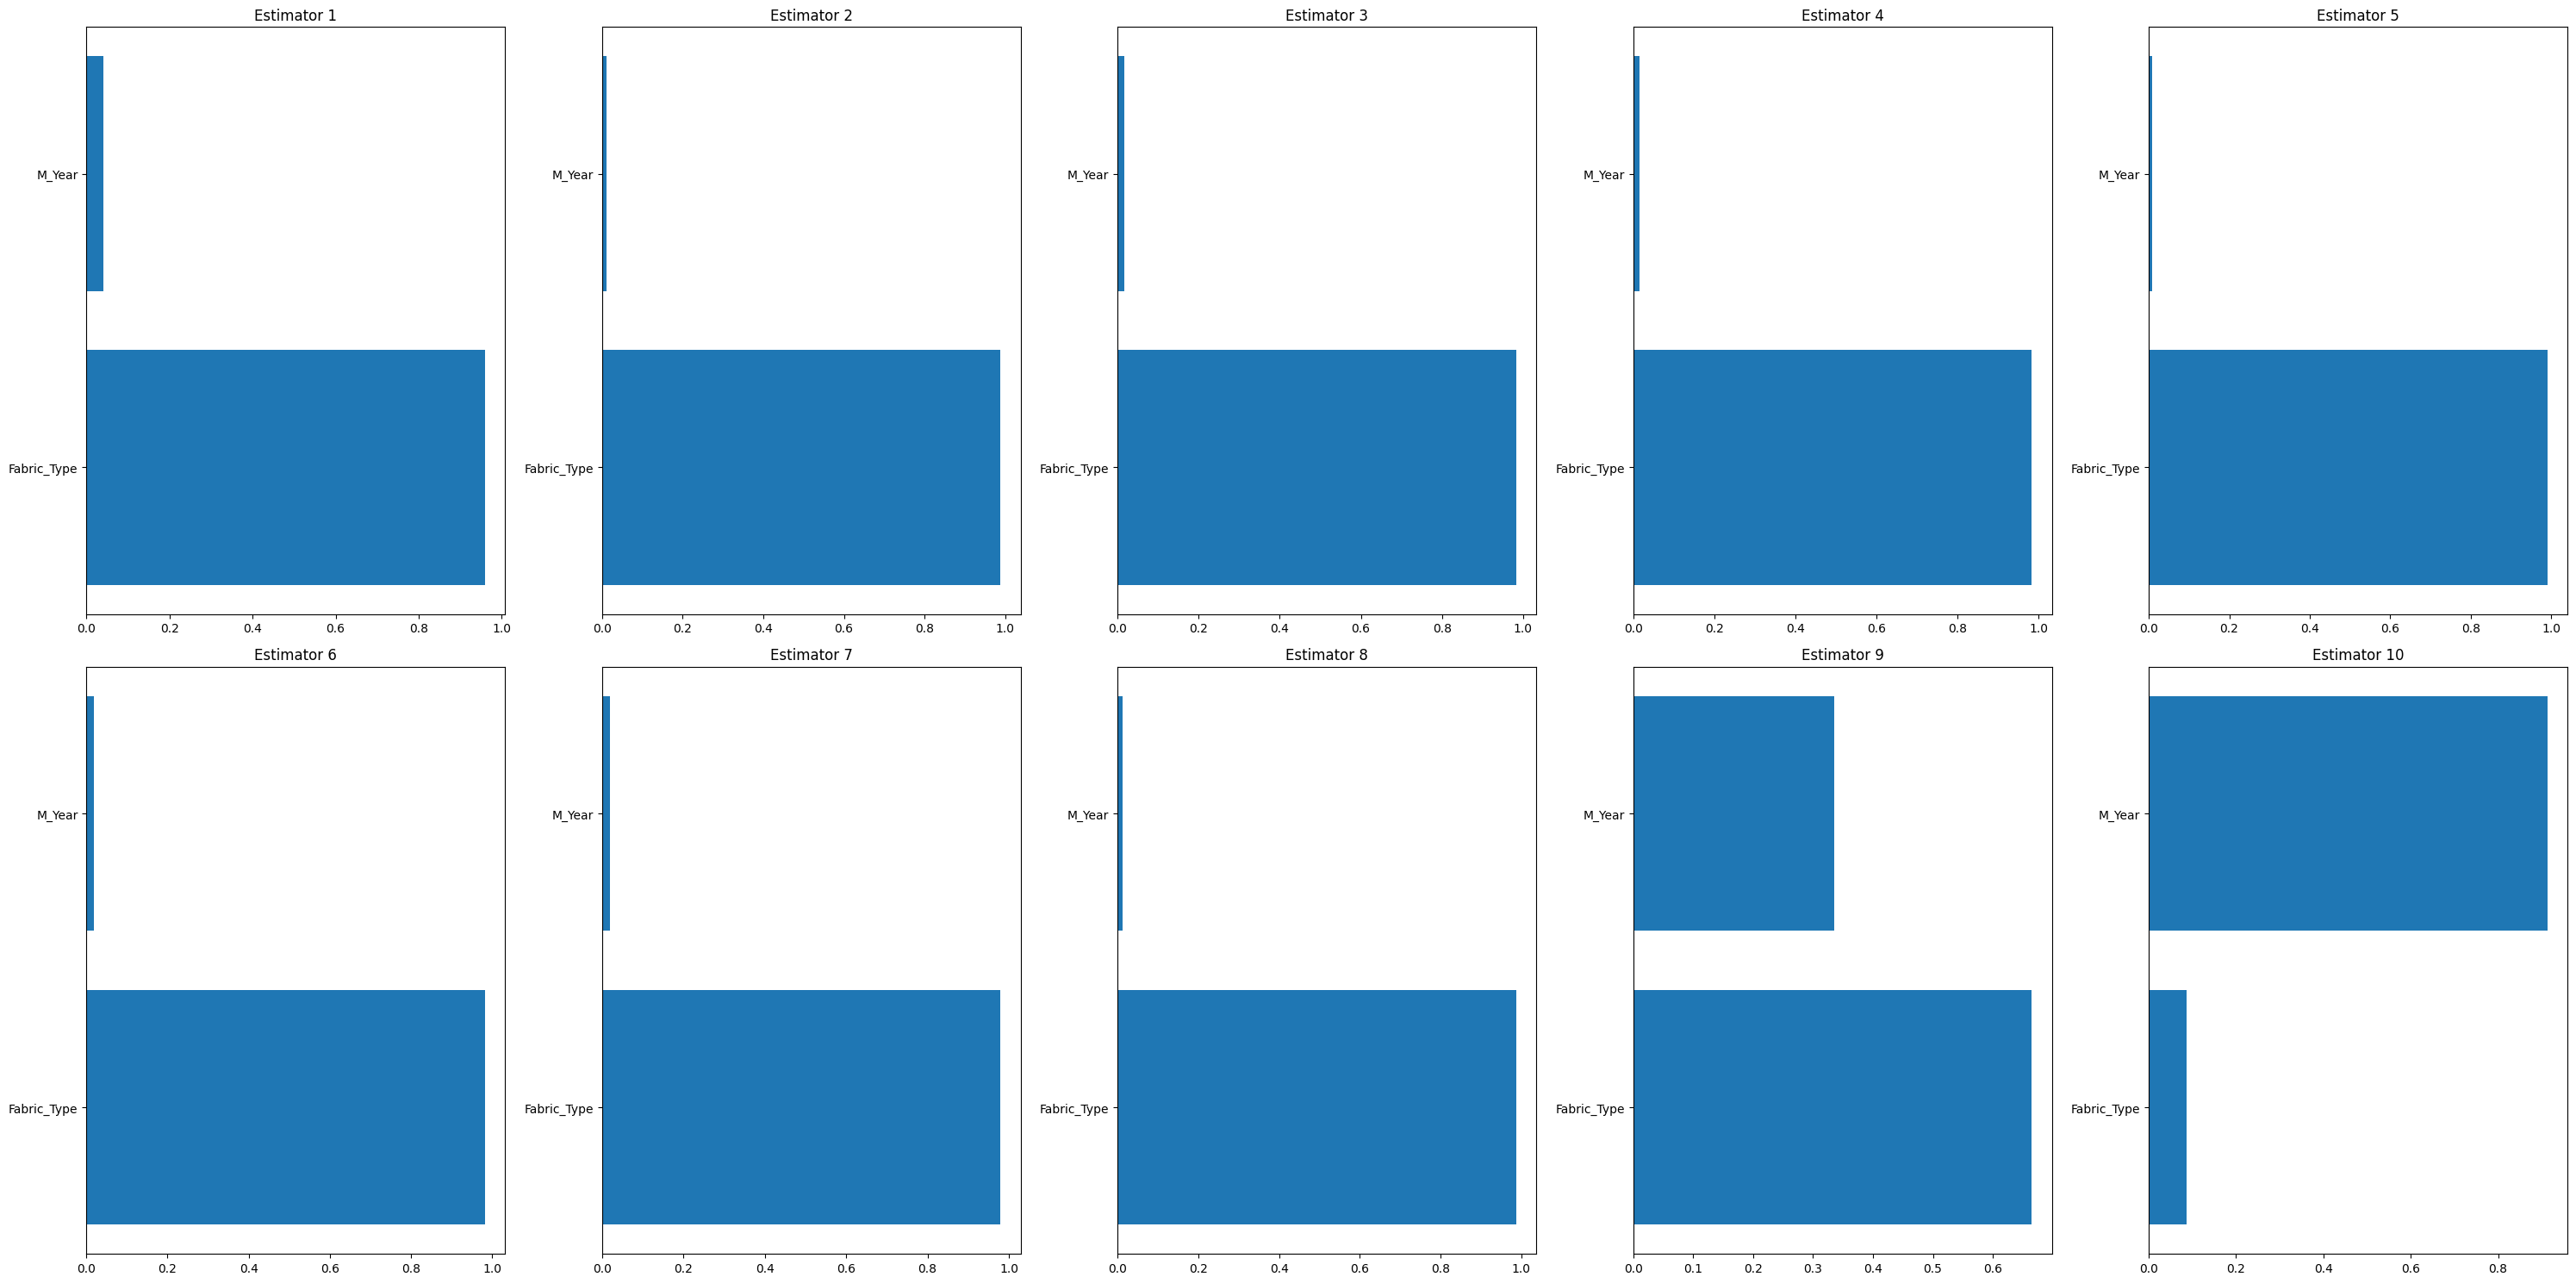

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 15))

num_estimators = len(rfr.estimators_)
num_columns = len(output_columns)

for i in range(min(num_estimators, num_columns)):
    rfr_importance = rfr.estimators_[i].feature_importances_
    plt.subplot(2, 5, i+1)
    plt.barh(range(X.shape[1]), rfr_importance)
    plt.yticks(range(X.shape[1]), ['Fabric_Type', 'M_Year'])  
    plt.ylim(-0.5, X.shape[1]-0.5)  
    plt.title("Estimator " + str(i+1))
    plt.tight_layout()  

plt.show()


In [8]:
#import matplotlib.pyplot as plt

#plt.figure(figsize=(30, 15))
#for i in range(len(output_columns)):
   # xgbr_importance = xgbr.estimators_[i].feature_importances_
  #  plt.subplot(2, 5, i+1)
  #  plt.barh(range(X.shape[1]), xgbr_importance)
  #  plt.yticks(range(X.shape[1]),['Fabric_Type', 'M_Year'])  # Replace your_feature_names_here with the actual names of your features
  #  plt.title(output_columns[i])
   # plt.tight_layout()  # Adjust layout for better spacing
#plt.show()


In [9]:
# save the model to disk
filename = 'data/xgb.pickle'
with open(filename, 'wb') as f:
    pickle.dump(xgbr, f)

# Output

In [10]:
with open('data/standard scalar.pkl', 'rb') as f:
    sc = pickle.load(f)

with open('data/xgb.pickle', 'rb') as f:
    xgbr = pickle.load(f)

In [11]:
def inference(
            sample_json,
            fabric_type_dict = {
                        'Heavy' : 1,
                        'Medium' : 0,
                        },
            output_columns = [
                        'Take up Spring', 'Take up Rubber', 'Bobbin Case', 'Feed Dog',
                        'Presser Foot', 'Tension Assembly', 'Hook Assembly',
                        'Timing Components','Oil Filling','Dust Remove'
                        ]
            ):
        sample = np.array([[
                        fabric_type_dict[sample_json['Fabric_Type']],
                        sample_json['M_Year']
                        ]])
        sample = sc.transform(sample)
        sample = sample.astype(np.float32)
        prediction = xgbr.predict(sample)
        prediction = prediction.squeeze()
        prediction = prediction.astype(np.int32)
        
        res_dict = {}
        usageDict = sample_json['usageDict']
        for i in range(len(output_columns)):
                used_hours = usageDict[output_columns[i]]
                pred_hours = prediction[i] - used_hours 
                pred_days = int(pred_hours / 8)
                future_date = datetime.datetime.now() + datetime.timedelta(days=int(pred_days))
                res_dict[output_columns[i]] = future_date.strftime("%Y-%m-%d %H:%M:%S")
        return res_dict
                

In [12]:
sample_json = {
            'Brand': 'Juki',
            'Type': 'Single needle',
            'Fabric_Type': 'Heavy', #GSM 400
            'M_Year': 2020,
            'usageDict': {
                        'Take up Spring': 170,
                        'Take up Rubber': 120,
                        'Bobbin Case': 500,
                        'Feed Dog': 600,
                        'Presser Foot': 500,
                        'Tension Assembly': 250,
                        'Hook Assembly': 125,
                        'Timing Components': 100,
                        'Oil Filling' :100,
                        'Dust Remove':50
                        }
            }

inference(sample_json)

{'Take up Spring': '2024-07-12 12:13:08',
 'Take up Rubber': '2024-06-05 12:13:08',
 'Bobbin Case': '2024-08-03 12:13:08',
 'Feed Dog': '2024-09-16 12:13:08',
 'Presser Foot': '2024-08-14 12:13:08',
 'Tension Assembly': '2024-10-25 12:13:08',
 'Hook Assembly': '2025-01-01 12:13:08',
 'Timing Components': '2025-03-03 12:13:08',
 'Oil Filling': '2024-05-04 12:13:08',
 'Dust Remove': '2024-09-16 12:13:08'}